In [219]:
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import seaborn as sns
import matplotlib.pyplot as plt

import pyodbc

In [220]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [221]:
#Database Credentials
server = 'MDZUSVPCWSQL020'
database = 'GPSReporting'
username = 'ISADev'
password = 'Fade2Bl@ck'

In [222]:
#Create SQL Connection String
connection_string = f'''
    DRIVER={{ODBC Driver 18 for SQL Server}};
    SERVER={server};
    DATABASE={database};
    UID={username};
    PWD={password};
    Encrypt=yes;
    TrustServerCertificate=yes;
'''

In [223]:
#Connect to database
connection = pyodbc.connect(connection_string)

In [224]:
datemap_query = """
SELECT Date, Planning_Week
FROM Reporting.Day_Calendar
WHERE Date >= '2022-01-01';
"""

In [225]:
#Pull in day -> week map
date_mapping = pd.read_sql_query(datemap_query, connection, dtype= {'Planning_Week': str})

C:\Users\BMZ7571\AppData\Local\Temp\ipykernel_19516\2966016825.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  date_mapping = pd.read_sql_query(datemap_query, connection, dtype= {'Planning_Week': str})


In [226]:
#Location Mapping
location_map_df = pd.read_excel(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\Simulation\Location Map.xlsx")

#Drop plants and random locations without good data
location_map_df = location_map_df.dropna()

#Convert IBL to integer for mapping
location_map_df['IBL'] = location_map_df['IBL'].astype(int)

#Create location mapping dictionary for each location
location_map = dict(zip(location_map_df['IBL'], location_map_df['Plant Type']))

In [227]:
def pallet_logic(pallets):
    '''Checks number of pallets sent out and applies MDLZ WW Block logic to them'''

    if pallets > 30:
        pallets = 30
    
    return pallets

In [ ]:
def add_zero(week) -> str:
    '''
    Appends a zero to single digit weeks

    args:
        week (int or float): Week of the year

    returns:
        str: the week of the year as a two digit string
    '''
    if len(week) < 2:
        week = "0" + week
        
    return week

In [229]:
#Add zeros to single digit weeks for joinability
date_mapping['week'] = date_mapping['Planning_Week'].apply(lambda x: add_zero(x))

In [230]:
#Add Year_Week column
date_mapping['Year_Week'] = (date_mapping['Date'].dt.year.astype(str) + date_mapping['Planning_Week']).astype(int)

#Add year column
date_mapping['year'] = date_mapping['Date'].dt.year

### Historical Outbound Demand

In [231]:
#Chicago
chicago_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Chicago_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
chicago_demand['Dest Plant Type'] = chicago_demand['DEST_KEY'].map(location_map)
chicago_demand['Picked Pallets'] = chicago_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

#Naperville
naperville_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Naperville_Outbound_Pallets.csv", parse_dates=['Delivery Date'])

#Portland 1143
portland_1143_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Portland_1143_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
portland_1143_demand['Dest Plant Type'] = portland_1143_demand['DEST_KEY'].map(location_map)
portland_1143_demand['Picked Pallets'] = portland_1143_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

#Portland
portland_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Portland_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
portland_demand['Dest Plant Type'] = portland_demand['DEST_KEY'].map(location_map)
portland_demand['Picked Pallets'] = portland_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

#Richmond 1144
richmond_1144_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Richmond_1144_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
richmond_1144_demand['Dest Plant Type'] = richmond_1144_demand['DEST_KEY'].map(location_map)
richmond_1144_demand['Picked Pallets'] = richmond_1144_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

#Richmond
richmond_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Richmond_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
richmond_demand['Dest Plant Type'] = richmond_demand['DEST_KEY'].map(location_map)
richmond_demand['Picked Pallets'] = richmond_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

#Texas
#texas_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Texas_6173_Outbound_Pallets.csv", parse_dates=['Delivery Date'])

#Salinas
salinas_demand = pd.read_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Salinas_Outbound_Pallets.csv", parse_dates=['Delivery Date'])
salinas_demand['Dest Plant Type'] = salinas_demand['DEST_KEY'].map(location_map)
salinas_demand['Picked Pallets'] = salinas_demand['Picked Pallets'].apply(lambda x: pallet_logic(x))

In [232]:
#Combine DCs w/ multiple locations
richmond_total_demand = pd.concat([richmond_demand, richmond_1144_demand])

portland_total_demand = pd.concat([portland_demand, portland_1143_demand])

In [233]:
def sat_sun_regressor(ds):
    '''
    Create binary regressor for the weekends.

    args:
        ds(pd.Series): Pandas series of dates
    returns:
        int: 0 for weekday 1 for weekend.
    '''
    #transform series to datetime if it is not already
    date = pd.to_datetime(ds)

    if date.weekday() == 5 or date.weekday() == 6:
        return 1
    else:
        return 0


In [234]:
def prep_daily_data_dsd(demand_df):
    '''
    Prepare daily demand data for use in Prophet algorithm.

    args:
        demand_df(pd.DataFrame): Pandas dataframe of location outbound pallet demand on a daily level
    returns:
        df(pd.DataFrame): Pandas dataframe of location outbound pallet demand
            properly formatted for use in Prophet algorithm. 
    '''
    #Group outbound demand by date & plant destination type - filter to DSD outbounds
    df = demand_df.groupby(['Delivery Date', 'Dest Plant Type'])['Picked Pallets'].sum().reset_index()
    df = df[df['Dest Plant Type'] == 'Branch']

    #Filter to relevant columns and rename for Prophet algo compatibility
    df = df[['Delivery Date', 'Picked Pallets']]
    df  = df.rename({'Delivery Date': 'ds', 'Picked Pallets': 'y'}, axis = 1)

    #Add weekend regressor
    df['weekend'] = df['ds'].apply(sat_sun_regressor)

    #Filter training data after 2023 & before 2025
    df = df[(df['ds'] < pd.to_datetime('2025-01-01')) & (df['ds'] >= pd.to_datetime('2023-01-01'))]

    #Filter outliers using IQR rule
    q1 = np.percentile(df['y'], 25)
    q3 = np.percentile(df['y'], 75)
    iqr = q3 - q1

    df = df[(df['y'] > q1 - 1.5 * iqr) & (df['y'] < q3 + 1.5 * iqr)]

    return df

In [235]:
def train_daily_prophet_model(df, model_type, cap):
    '''
    Set up and train a Prophet time series forecasting model for outbound demand.

    args:
        df(pd.DataFrame): dataframe output of prep_data() function
    returns:
        preds(pd.Dataframe): Outbound demand predictions of the Prophe model
    '''
    if model_type == 'logistic':
        #Instantiate Prophet model and fit data
        df['cap'] = cap
        df['floor'] = 0
        model = Prophet(growth='logistic', changepoint_prior_scale=0.025)
        model.add_regressor('weekend')
        model.fit(df)

        #Set up dataframe with dates 52 weeks into the future from the training data
        future_df = model.make_future_dataframe(periods = 365, freq = 'D')
        future_df['weekend'] = future_df['ds'].apply(sat_sun_regressor)
        future_df['cap'] = cap
        future_df['floor'] = 0
    else:
        #Instantiate Prophet model and fit data
        model = Prophet(changepoint_prior_scale=0.025)
        model.add_regressor('weekend')
        model.fit(df)

        #Set up dataframe with dates 52 weeks into the future from the training data
        future_df = model.make_future_dataframe(periods = 365, freq = 'D')
        future_df['weekend'] = future_df['ds'].apply(sat_sun_regressor)

    #Make weekly predictions out a year
    preds = model.predict(future_df)

    #Make sure forecast excludes previous actual data
    preds = preds[preds['ds'] > df['ds'].max()]

    #Plot predictions
    fig = model.plot(preds)

    #Plot model components
    components = model.plot_components(preds)

    #Perform cross validation
    cv = cross_validation(model, initial = '365 days', period = '60 days', horizon= '120 days')

    #Plot MAPE cross validation
    plot_cross_validation_metric(cv, metric = 'mape')

    #Calculate performance metrics
    pm = performance_metrics(cv)

    return preds, pm

In [236]:
def prep_weekly_data(demand_df):
    '''
    Prepare weekly demand data for use in Prophet algorithm.

    args:
        demand_df(pd.DataFrame): Pandas dataframe of location outbound pallet demand on a daily level
    returns:
        df(pd.DataFrame): Pandas dataframe of location outbound pallet demand,
            grouped by week and properly formatted for use in Prophet algorithm. 
    '''
    #Add operational week mapping for grouping
    df = demand_df.merge(date_mapping, left_on = 'Delivery Date', right_on = 'Date').drop('Date', axis = 1)

    #Group outbound demand by operational week
    df = df.groupby('Year_Week')['Picked Pallets'].sum().reset_index()

    #Reintroduce dates for compatability with Prophet algo
    df = df.merge(date_mapping, on = 'Year_Week').drop_duplicates(subset='Year_Week', keep = 'first')

    #Filter to relevant columns and rename for Prophet algo compatibility
    df = df[['Date', 'Picked Pallets']]
    df  = df.rename({'Date': 'ds', 'Picked Pallets': 'y'}, axis = 1)

    #Filter training data after 2023 & before 2025
    #df = df[(df['ds'] < pd.to_datetime('2025-01-01')) & (df['ds'] >= pd.to_datetime('2023-01-01'))]
    df = df[(df['ds'] >= pd.to_datetime('2023-01-08')) & (df['ds'] <= pd.to_datetime('2025-02-09'))]

    #Filter outliers using IQR rule
    q1 = np.percentile(df['y'], 25)
    q3 = np.percentile(df['y'], 75)
    iqr = q3 - q1

    df = df[(df['y'] > q1 - 1.5 * iqr) & (df['y'] < q3 + 1.5 * iqr)]

    return df

In [237]:
def train_weekly_prophet_model(df, model_type, cap):
    '''
    Set up and train a Prophet time series forecasting model for outbound demand.

    args:
        df(pd.DataFrame): dataframe output of prep_data() function
    returns:
        preds(pd.Dataframe): Outbound demand predictions of the Prophe model
    '''
    if model_type == 'logistic':
        #Instantiate Prophet model and fit data
        df['cap'] = cap
        df['floor'] = 0
        model = Prophet(growth='logistic')
        model.fit(df)

        #Set up dataframe with dates 52 weeks into the future from the training data
        future_df = model.make_future_dataframe(periods = 52, freq = 'W')
        future_df['cap'] = cap
        future_df['floor'] = 0
    else:
        #Instantiate Prophet model and fit data
        model = Prophet()
        model.fit(df)

        #Set up dataframe with dates 99 weeks into the future from the training data
        future_df = model.make_future_dataframe(periods = 99, freq = 'W')

    #Make weekly predictions out a year
    preds = model.predict(future_df)

    #Make sure forecast excludes previous actual data
    preds = preds[preds['ds'] > df['ds'].max()]
    
    #Plot predictions
    fig = model.plot(preds)

    #Plot model components
    components = model.plot_components(preds)

    #Perform cross validation
    cv = cross_validation(model, initial = '52 W', period = '13 W', horizon= '26 W')

    #Plot MAPE cross validation
    plot_cross_validation_metric(cv, metric = 'mape')

    #Calculate performance metrics
    pm = performance_metrics(cv)

    return preds, pm

In [238]:
def calc_dist_proportions(df):
    '''
    Calculate proportion of distribution split between RDC & DSD

    args:
        df(pd.DataFrame): dataframe of historical outbound volume by locaiton
    returns:
        rdc_prop(np.float): Proportion of outbound pallets location sends to rdc on average
        dsd_prop(np.float): Proportion of outbound pallets location sends to dsd on average
    '''
    grouped = df.groupby('Dest Plant Type')['Picked Pallets'].sum().reset_index()

    rdc_prop = grouped[grouped['Dest Plant Type'] == 'RDC']['Picked Pallets'].values[0] / (grouped[grouped['Dest Plant Type'] == 'RDC']['Picked Pallets'].values[0] + grouped[grouped['Dest Plant Type'] == 'Branch']['Picked Pallets'].values[0])
    dsd_prop = grouped[grouped['Dest Plant Type'] == 'Branch']['Picked Pallets'].values[0] / (grouped[grouped['Dest Plant Type'] == 'RDC']['Picked Pallets'].values[0] + grouped[grouped['Dest Plant Type'] == 'Branch']['Picked Pallets'].values[0])

    return rdc_prop, dsd_prop

----

### Calculate Location Distributions

In [239]:
#Salinas
salinas_rdc_prop, salinas_dsd_prop = calc_dist_proportions(salinas_demand)

#Richmond
richmond_rdc_prop, richmond_dsd_prop = calc_dist_proportions(richmond_total_demand)

#Chicago
chicago_rdc_prop, chicago_dsd_prop = calc_dist_proportions(chicago_demand)

#Portland
portland_rdc_prop, portland_dsd_prop = calc_dist_proportions(portland_total_demand)

### Model Results

Salinas

12:23:56 - cmdstanpy - INFO - Chain [1] start processing
12:23:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

  0%|          | 0/3 [00:00<?, ?it/s]

12:23:56 - cmdstanpy - INFO - Chain [1] start processing
12:23:56 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


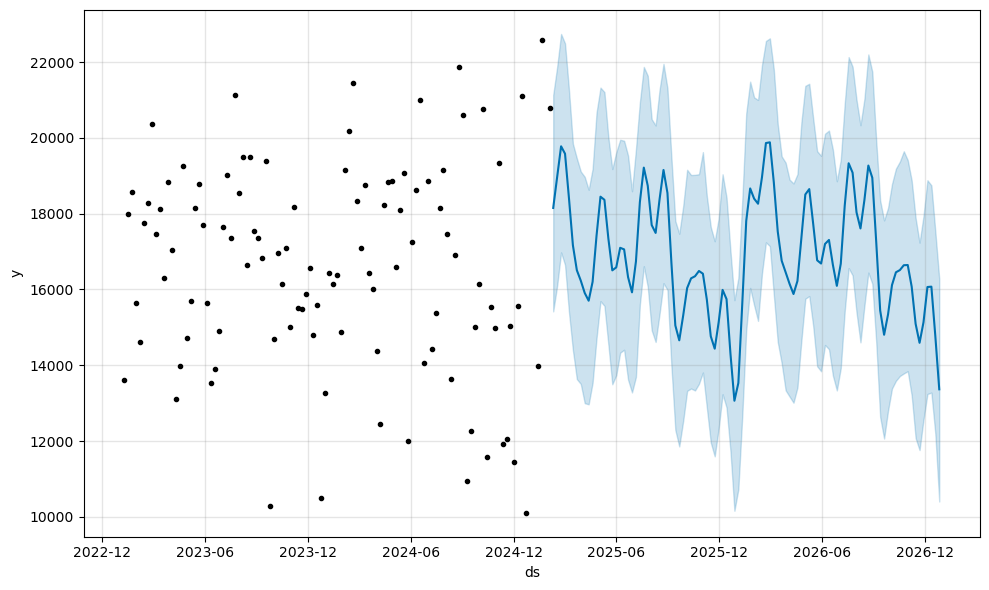

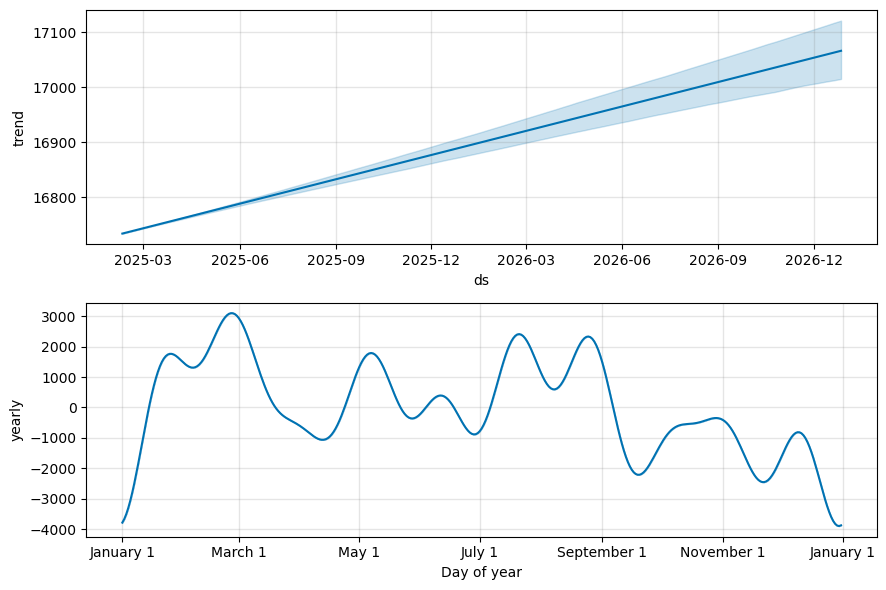

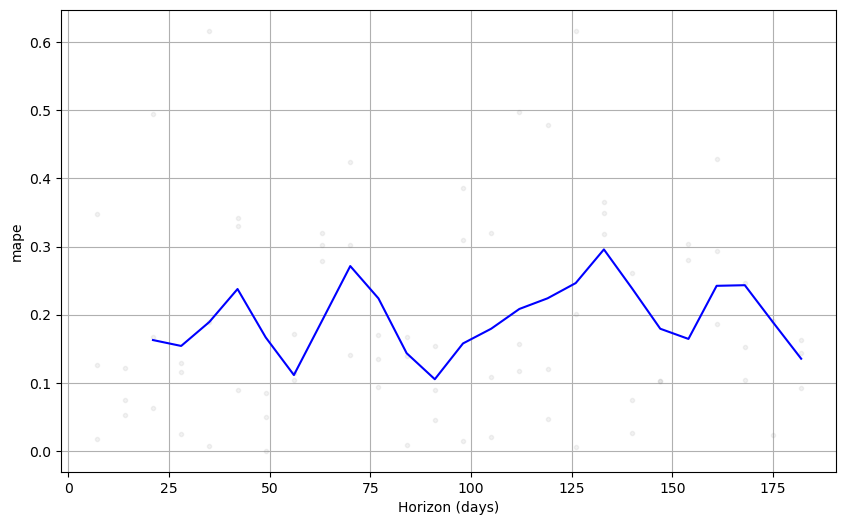

In [240]:
salinas_forecast, salinas_pm = train_weekly_prophet_model(prep_weekly_data(salinas_demand), 'linear', 2000)

In [241]:
salinas_forecast['RDC'] = round(salinas_forecast['yhat'] * salinas_rdc_prop).astype('int64')
salinas_forecast['Branch'] = round(salinas_forecast['yhat'] * salinas_dsd_prop).astype('int64')

In [242]:
salinas_forecast = salinas_forecast[['ds', 'RDC', 'Branch']]

Richmond

12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

  0%|          | 0/3 [00:00<?, ?it/s]

12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:59 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


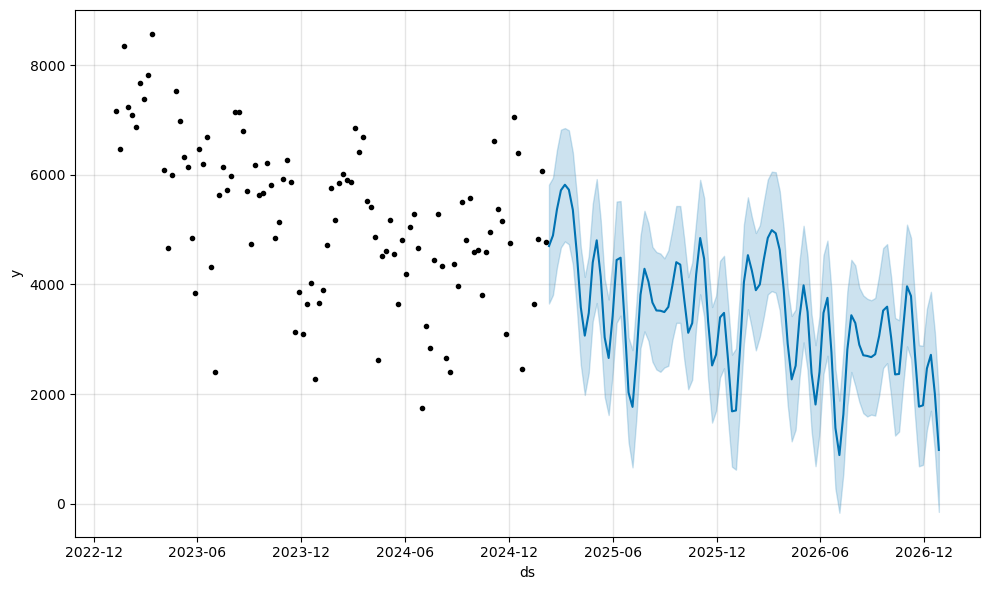

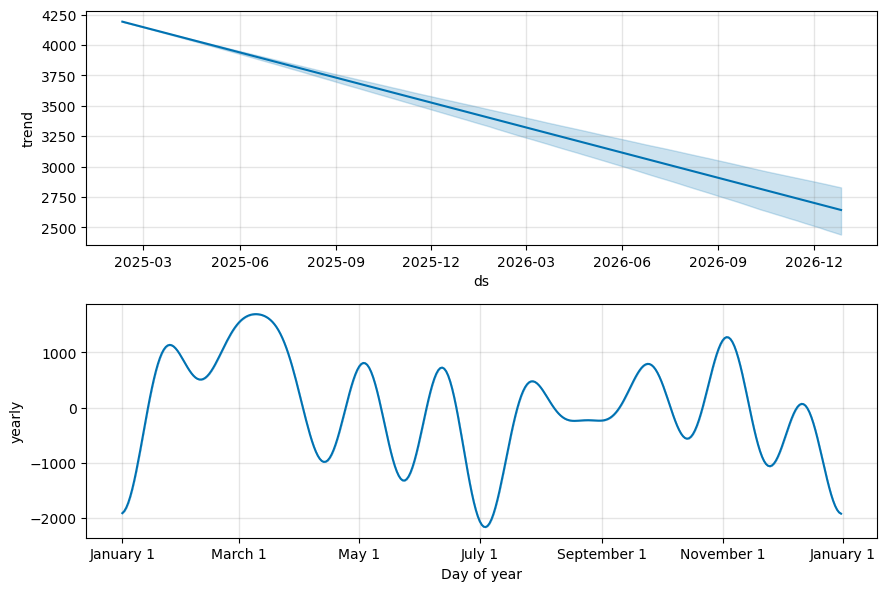

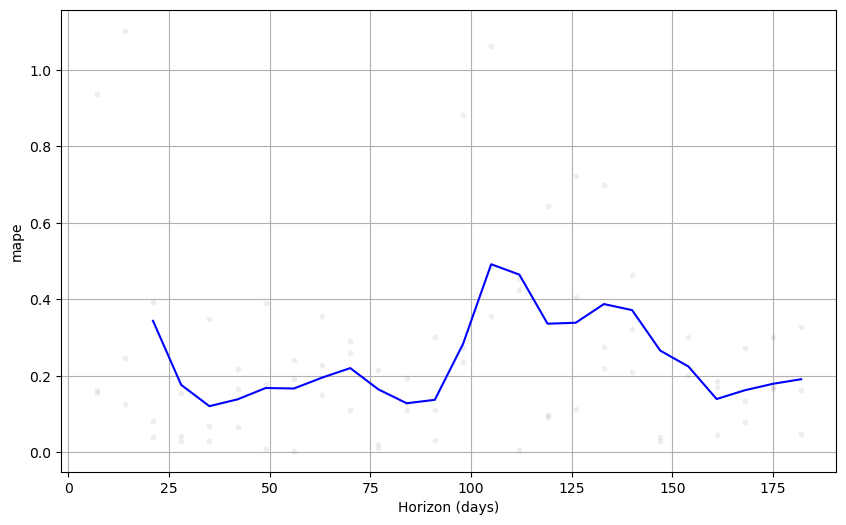

In [243]:
#Train Richmond outbound demand model
richmond_forecast, richmond_pm = train_weekly_prophet_model(prep_weekly_data(richmond_total_demand), 'linear', 500)

In [244]:
richmond_forecast['RDC'] = round(richmond_forecast['yhat'] * richmond_rdc_prop)
richmond_forecast['Branch'] = round(richmond_forecast['yhat'] * richmond_dsd_prop)

In [245]:
richmond_forecast = richmond_forecast[['ds', 'RDC', 'Branch']]

Portland

12:23:59 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

  0%|          | 0/3 [00:00<?, ?it/s]

12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


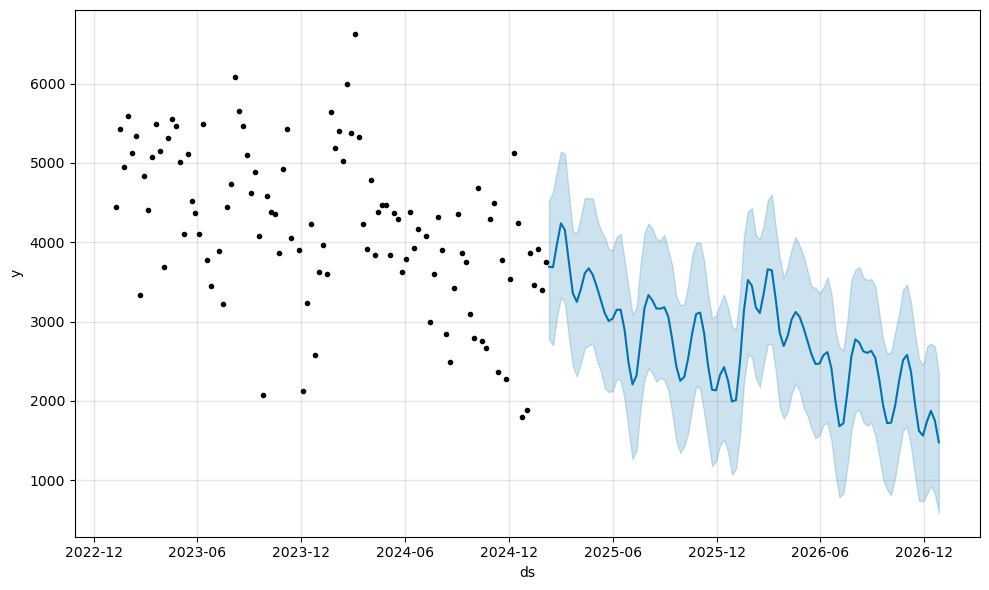

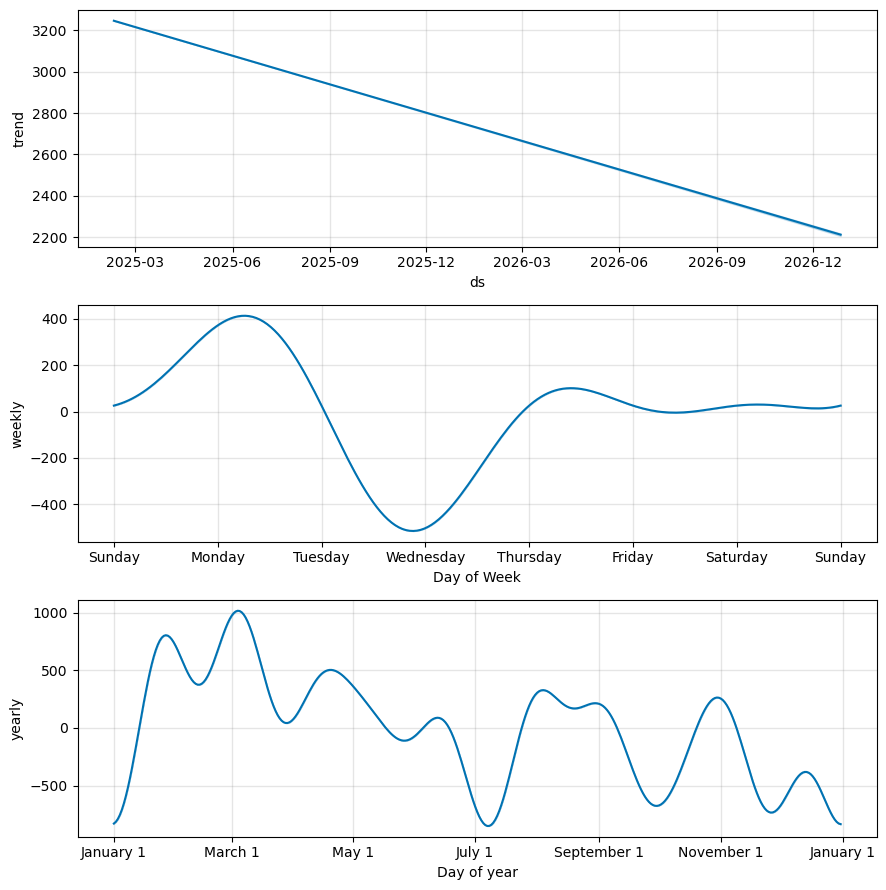

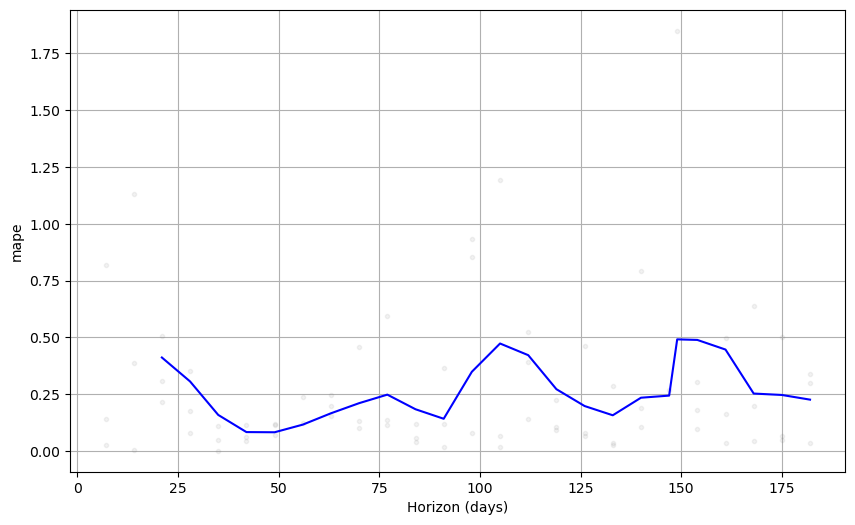

In [246]:
#Train Portland outbound demand model
portland_forecast, portland_pm = train_weekly_prophet_model(prep_weekly_data(portland_total_demand),'linear', 2500)

In [247]:
portland_forecast['RDC'] = round(portland_forecast['yhat'] * portland_rdc_prop)
portland_forecast['Branch'] = round(portland_forecast['yhat'] * portland_dsd_prop)

In [248]:
portland_forecast = portland_forecast[['ds', 'RDC', 'Branch']]

Naperville

12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

  0%|          | 0/3 [00:00<?, ?it/s]

12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


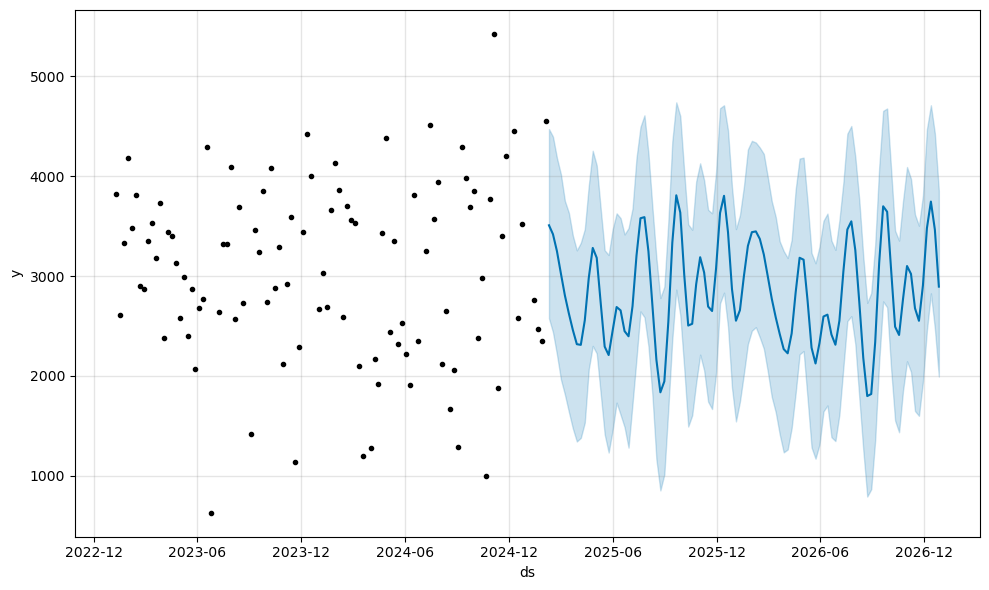

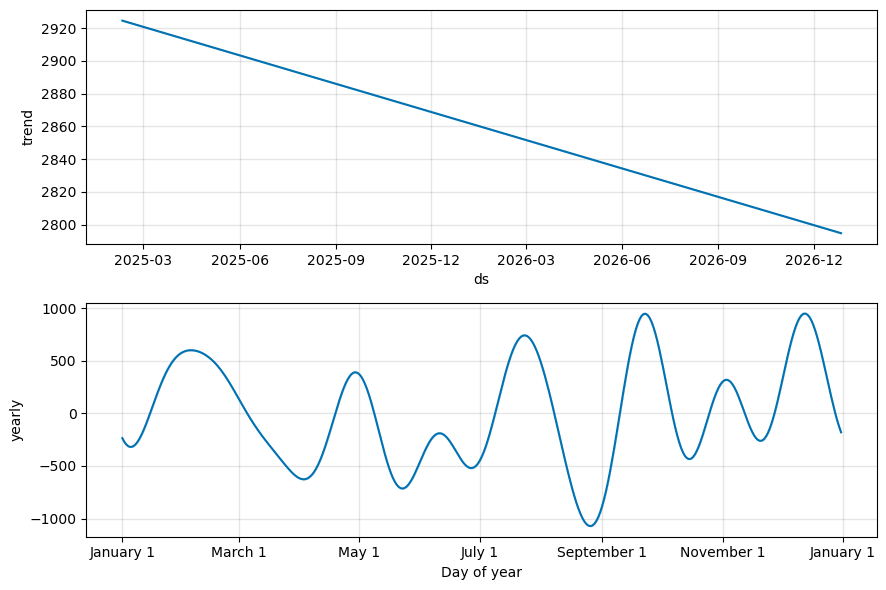

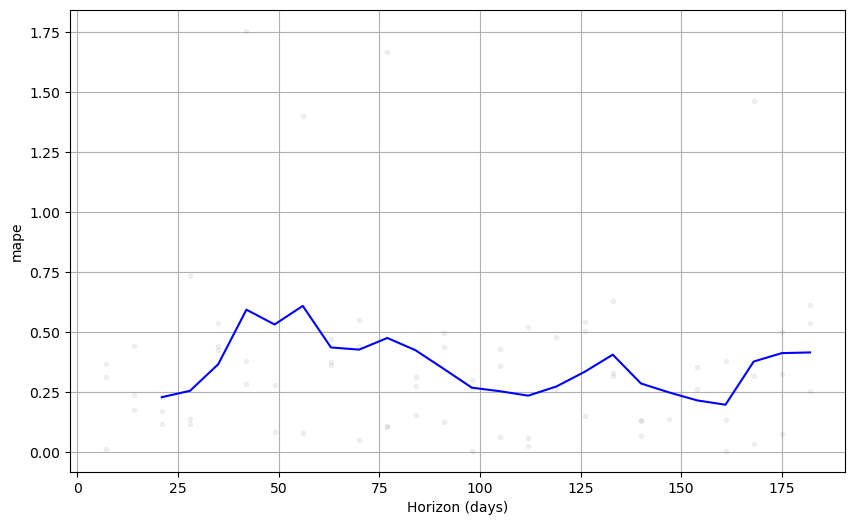

In [249]:
#Train Naperville outbound demand model
naperville_forecast, naperville_pm = train_weekly_prophet_model(prep_weekly_data(naperville_demand), 'linear', 1300)

In [250]:
naperville_forecast['RDC'] = round(naperville_forecast['yhat']).astype('int64')
#Naperville doesn't send pallets to branches
naperville_forecast['Branch'] = 0

Chicago

12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

  0%|          | 0/3 [00:00<?, ?it/s]

12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\BMZ7571\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


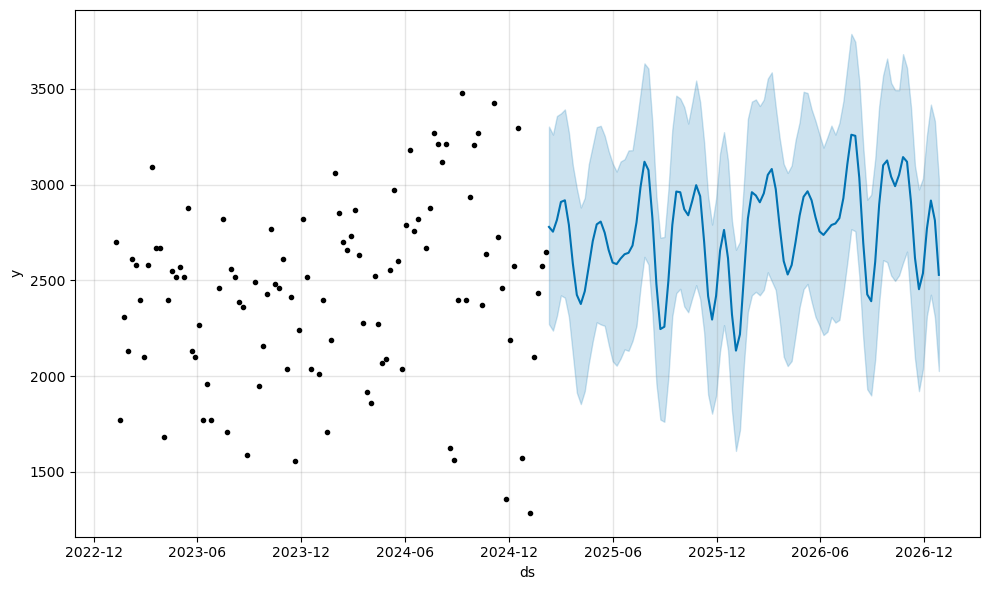

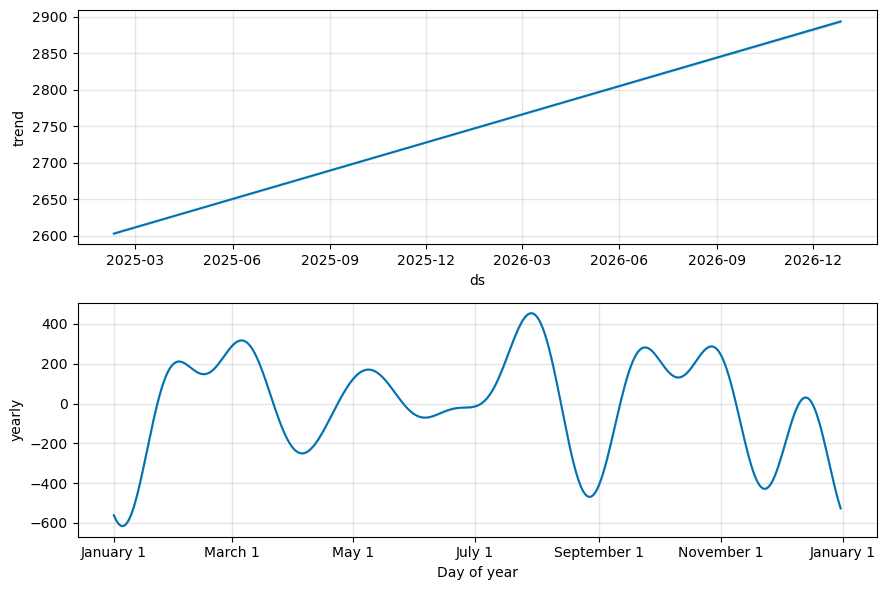

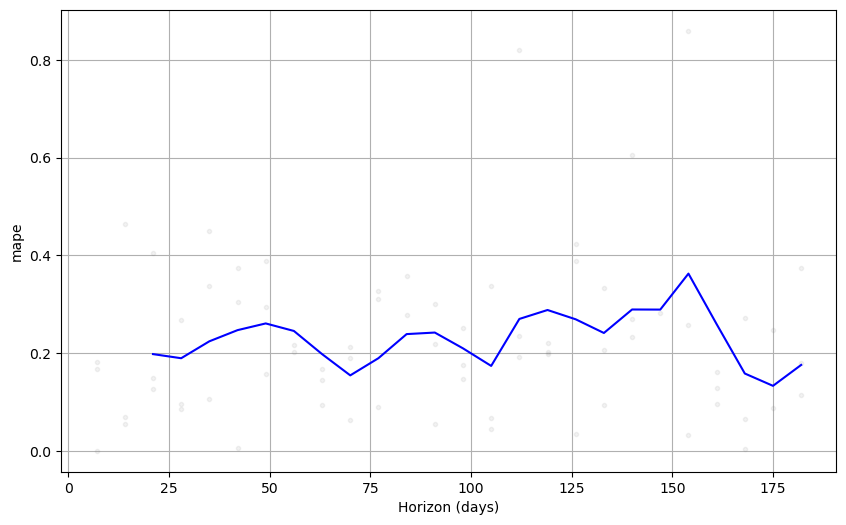

In [251]:
#Train Chicago outbound demand model
chicago_forecast, chicago_pm = train_weekly_prophet_model(prep_weekly_data(chicago_demand), 'linear', 1600)

In [252]:
chicago_forecast['RDC'] = round(chicago_forecast['yhat'] * chicago_rdc_prop).astype('int64')
chicago_forecast['Branch'] = round(chicago_forecast['yhat'] * chicago_dsd_prop).astype('int64')

In [253]:
chicago_forecast = chicago_forecast[['ds', 'RDC', 'Branch']]

### File Ouputs

Salinas

In [254]:
#Merge week and year on for joining purposes
salinas_forecast = salinas_forecast.merge(date_mapping, left_on = 'ds', right_on = 'Date').reset_index()

#Filter to used columns in simulation
salinas_forecast = salinas_forecast[['year', 'week', 'RDC', 'Branch']]

In [255]:
#Output file
salinas_forecast.to_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Outbound Demand Forecasts\salinas_forecast.csv", index=False)

Richmond

In [256]:
#Merge week and year on for joining purposes
richmond_forecast = richmond_forecast.merge(date_mapping, left_on = 'ds', right_on = 'Date').reset_index()

#Filter to used columns in simulation
richmond_forecast = richmond_forecast[['year', 'week', 'RDC', 'Branch']]

In [257]:
#Output file
richmond_forecast.to_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Outbound Demand Forecasts\richmond_forecast.csv", index=False)

Portland

In [258]:
#Merge week and year on for joining purposes
portland_forecast = portland_forecast.merge(date_mapping, left_on = 'ds', right_on = 'Date').reset_index()

#Filter to used columns in simulation
portland_forecast = portland_forecast[['year', 'week', 'RDC', 'Branch']]

In [259]:
#Output file
portland_forecast.to_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Outbound Demand Forecasts\portland_forecast.csv", index=False)

Chicago

In [260]:
#Merge week and year on for joining purposes
chicago_forecast = chicago_forecast.merge(date_mapping, left_on = 'ds', right_on = 'Date').reset_index()

#Filter to used columns in simulation
chicago_forecast = chicago_forecast[['year', 'week', 'RDC', 'Branch']]

In [261]:
#Output file
chicago_forecast.to_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Outbound Demand Forecasts\chicago_forecast.csv", index=False)

Naperville

In [262]:
#Merge week and year on for joining purposes
naperville_forecast = naperville_forecast.merge(date_mapping, left_on = 'ds', right_on = 'Date').reset_index()

#Filter to used columns in simulation
naperville_forecast = naperville_forecast[['year', 'week', 'RDC', 'Branch']]

In [263]:
#Output file
naperville_forecast.to_csv(r"\\mznapwapalt002\alteryx\NA_BIS\Everything On Pallets\SAP Data\Outbound Demand Forecasts\naperville_forecast.csv", index=False)